#### Survival analysis

In [1]:
from sksurv.nonparametric import kaplan_meier_estimator
from scipy import stats
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

#### EXAMPLE

Let's do a survival function estimation example using artifically generated data.

Say that we are observing the first-failure times of a process, which follow an exponential distribution with a mean of 10 years. Note in `scipy`, we feed in the mean as the `scale` parameter. Let's say we make 100 observations. We can generate that below:

In [2]:
mean_time = 10
num_observations = 100
seed = 42

true_time_to_fail = stats.expon(scale=mean_time).rvs(num_observations, random_state=seed)
true_time_to_fail[:10], true_time_to_fail.mean()

(array([ 4.6926809 , 30.10121431, 13.16745694,  9.12942554,  1.6962487 ,
         1.69596292,  0.59838769, 20.11230864,  9.19082154, 12.31250062]),
 9.147480390388715)

We can complicate things by assuming we only run this experiment for 15 years total, with our 100 observations' start times uniformly distributed within the duration of the experiment. Any processes that haven't failed by the time the experiment ends are considered "censored".

In [3]:
duration = 15

start_times = stats.uniform(scale=15).rvs(num_observations, random_state=seed**2)
end_times = start_times + true_time_to_fail

# stack true end times and max observable end time along axis=0
stacked = np.vstack((end_times, duration * np.ones_like(end_times)))
# take the minimum along axis=0 to censor the data
censored_end_times = np.min(stacked, axis=0)

# compute the observed end time by subtracting off the start time
observed_time_to_fail = censored_end_times - start_times

# determine whether the observation was censored or not
observation_was_uncensored = end_times == censored_end_times
observed_time_to_fail[:10], observation_was_uncensored[:10]

(array([ 4.6926809 ,  0.10704622,  1.59668398,  9.12942554,  1.6962487 ,
         1.69596292,  0.59838769, 10.82104519,  9.19082154,  6.71269244]),
 array([ True, False, False,  True,  True,  True,  True, False,  True,
        False]))

Now, we have an array of times that represent __the latest time in a process's lifetime that we knew it had not yet failed__, as well as an array of booleans that tell us whether each process was censored. This is what is observable in the context of right-censored survival times.

Now, we can use the Kaplan-Meier estimator of the survival function via `scikit-survival`'s implementation.

In [4]:
times, surv_func, conf_int = kaplan_meier_estimator(observation_was_uncensored, observed_time_to_fail, conf_type='log-log')

And we can plot our result, alongside the true survival function of an exponential distribution for comparison.

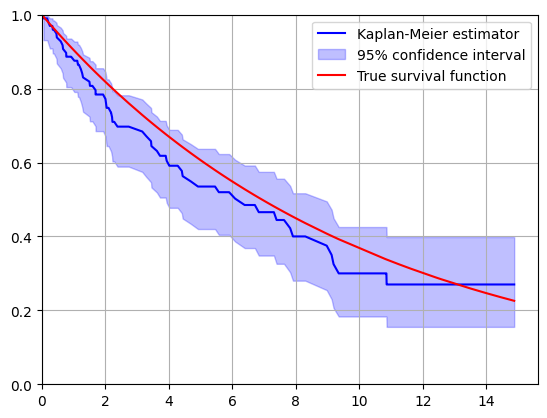

In [5]:
plt.plot(times, surv_func, c='b', label='Kaplan-Meier estimator')
plt.fill_between(times, conf_int[0], conf_int[1], color='b', alpha=0.25, label='95% confidence interval');

plt.plot(times, stats.expon(scale=mean_time).sf(times), c='r', label='True survival function')

plt.grid()
plt.legend()
plt.ylim(0,1)
plt.xlim(0,None);

In [6]:
help(stats.weibull_max)

Help on weibull_max_gen in module scipy.stats._continuous_distns:

<scipy.stats._continuous_distns.weibull_max_gen object>
    Weibull maximum continuous random variable.
    
    The Weibull Maximum Extreme Value distribution, from extreme value theory
    (Fisher-Gnedenko theorem), is the limiting distribution of rescaled
    maximum of iid random variables. This is the distribution of -X
    if X is from the `weibull_min` function.
    
    As an instance of the `rv_continuous` class, `weibull_max` object inherits from it
    a collection of generic methods (see below for the full list),
    and completes them with details specific for this particular distribution.
    
    Methods
    -------
    rvs(c, loc=0, scale=1, size=1, random_state=None)
        Random variates.
    pdf(x, c, loc=0, scale=1)
        Probability density function.
    logpdf(x, c, loc=0, scale=1)
        Log of the probability density function.
    cdf(x, c, loc=0, scale=1)
        Cumulative distribution fun

### REPLICATED R CODE

#### Read in PVROM/EPRI data

_____IMPORTANT_____: reading in this feather file requires `pyarrow`. also, data files read in here are not on the remote repository

In [7]:
OM_df = pd.read_feather('example_data/R/OMRecords_AllDetails_PostML_Mar122020.feather')
meta_df = pd.read_feather('example_data/R/Sites_AllMetadata_Mar302020.feather')
EPRI_df = pd.read_csv('example_data/R/Proprietary_EPRI_CMwithMetadata_PostML.csv')

PVROM_df = OM_df[OM_df['WOType'] == 'Corrective'].merge(meta_df, on='randid', how='left')
del OM_df, meta_df

DF1 = (PVROM_df
       .assign(FullDesc=lambda x: x['GeneralDesc'] + '. ' + x['CompletionDesc'])
       .rename(columns={'Date_EventStart_Consistent': 'EventStart',
                        'Date_EventEnd_Consistent': 'EventEnd'})
       .assign(COD=lambda x: pd.to_datetime(x['COD']),
               COD_yr=lambda x: x['COD'].dt.year,
               COD_mo=lambda x: x['COD'].dt.month)
       .loc[:, ['randid', 'Mo_DateReported', 'states', 'ClimateZ', 'InverterType', 
                 'Dataset', 'FullDesc', 'EventStart', 'EventEnd', 'COD', 
                 'COD_yr', 'COD_mo', 'Asset', 'Asset_Simple', 
                 'Asset_Simple_mlupdate', 'AC_Size_kW', 'DC_Size_kW']])

DF1['EventStart'] = pd.to_datetime(DF1['EventStart'].astype(str).str.split('+').str[0])
DF1['EventEnd'] = pd.to_datetime(DF1['EventEnd'].astype(str).str.split('+').str[0])

In [8]:
DF2 = (EPRI_df
       .assign(InverterType=lambda x: x['Site'].apply(lambda site: 'String' if site == 'Halifax Solar' else 'Central'),
               randid=lambda x: x['SiteID'].astype(str),
               Dataset='EPRI1',
               ClimateZ=lambda x: x['ClimType1'] + x['ClimType2'] + x['ClimType3'],
               Mo_DateReported=lambda x: pd.to_numeric(pd.to_datetime(x['ReportedDate_fmt']).dt.month),
               states=lambda x: x['State'],
               FullDesc=lambda x: x['Description'] + '. ' + x['ResponseDescription'],
               EventStart=lambda x: pd.to_datetime(x['WorkBeginUtc'], format='%m/%d/%Y %H:%M'),
               EventEnd=lambda x: pd.to_datetime(x['WorkEndUtc'], format='%m/%d/%Y %H:%M'),
               COD=lambda x: pd.to_datetime(x['COD']),
               COD_yr=lambda x: x['COD'].dt.year,
               COD_mo=lambda x: x['COD'].dt.month,
               Asset=lambda x: x['FailProb_Clean'],
               AC_Size_kW=lambda x: x['AC_kW'],
               DC_Size_kW=lambda x: x['DC_kW'],
               Asset_Simple=lambda x: x['FailProb_Clean'].apply(lambda val: 
                   'Inverter' if val in ['INVERTER', 'INVERTERS', 'INVERTER COOLING', 'INVERTER GROUND FAULT'] else
                   'Combiner' if val in ['COMBINER', 'COMBINER BOXES'] else
                   'Tracker' if val in ['TRACKER', 'TR-GEAR', 'TRACKERS'] else
                   'Transformer' if val in ['TRANSFORMERS', 'TRANS'] else
                   'Facility' if val == 'FACILITY' else
                   None if val in ['GENERAL', 'MISC', ''] else
                   'Other'),
               Asset_Simple_mlupdate=lambda x: x['Asset_Simple'].where(x['Asset_Simple'].notna(), x['failcats_postml']).apply(lambda val: 
                   'Tracker' if val in ['trgear', 'tracker'] else
                   'Transformer' if val == 'trans' else
                   'Inverter' if val == 'inverter' else
                   'Combiner' if val in ['combiner', 'combinerboxes'] else
                   'Other'))
       .loc[:, ['randid', 'Mo_DateReported', 'states', 'ClimateZ', 'InverterType', 
                 'Dataset', 'FullDesc', 'EventStart', 'EventEnd', 'COD', 
                 'COD_yr', 'COD_mo', 'Asset', 'Asset_Simple', 
                 'Asset_Simple_mlupdate']])


#### Function definitions

In [9]:
# Combine DF1 and DF2
C_all_om = pd.concat([DF1, DF2], ignore_index=True)
# C_all_om = DF1.copy()
# C_all_om = C_all_om.dropna(subset=['EventStart','EventEnd','COD'])

# Mutate and transform the DataFrame
C_all_om['states'] = C_all_om['states'].replace({
    "AZ": "Arizona",
    "CO": "Colorado",
    "CA": "California",
    "FL": "Florida",
    "NC": "North Carolina",
    "NM": "New Mexico",
    "TX": "Texas"
}).fillna(C_all_om['states'])

C_all_om['states'] = C_all_om['states'].astype('category')
C_all_om['ClimateZ'] = C_all_om['ClimateZ'].str.lower().astype('category')
C_all_om['InverterType'] = C_all_om['InverterType'].str.lower()

C_all_om['InverterType'] = C_all_om['InverterType'].replace({
    "string, central": "mixed",
    "string; central": "mixed",
    "central; string": "mixed",
    "n/a": "unknown"
}).fillna("unknown")

C_all_om['InverterType'] = C_all_om['InverterType'].astype('category')
C_all_om['Mo_DateReported'] = C_all_om['EventStart'].dt.month
C_all_om['Dataset'] = C_all_om['Dataset'].astype('category')

# Create Climate column based on ClimateZ
C_all_om['Climate'] = C_all_om['ClimateZ'].replace({
    "af": "Tropical",
    "as": "Tropical",
    "bsh": "Arid",
    "bsk": "Arid",
    "bwh": "Arid",
    "bwk": "Arid",
    "csa": "Temperate Dry",
    "csb": "Temperate Dry",
    "dfa": "Cold",
    "dfb": "Cold",
    "cfa": "Temperate Non-Dry",
    "cfb": "Temperate Non-Dry"
})

# Filter out rows where randid is NA
C_all_om = C_all_om[C_all_om['randid'].notna()]

C:\Users\agmoore\AppData\Local\Temp\ipykernel_27896\3204371693.py:33: FutureWarning: The behavior of Series.replace (and DataFrame.replace) with CategoricalDtype is deprecated. In a future version, replace will only be used for cases that preserve the categories. To change the categories, use ser.cat.rename_categories instead.
  C_all_om['Climate'] = C_all_om['ClimateZ'].replace({


In [10]:
# DataFrame with just inverter records
C_inverter_om = (C_all_om
                 .loc[(C_all_om['Asset_Simple_mlupdate'] == "Inverter") & (C_all_om['COD'].notna()), 
                      ['randid', 'Mo_DateReported', 'states', 'Climate', 'ClimateZ', 
                       'InverterType', 'Dataset', 'FullDesc', 'EventStart', 
                       'EventEnd', 'COD', 'COD_yr', 'COD_mo', 
                       'Asset_Simple_mlupdate', 'AC_Size_kW', 'DC_Size_kW']]
                 .dropna(subset=['Mo_DateReported']))

# Just site-level info
C_all_meta = C_all_om[['randid', 'states', 'Climate', 'ClimateZ', 
                        'InverterType', 'Dataset', 'COD', 
                        'COD_yr', 'COD_mo', 'AC_Size_kW', 
                        'DC_Size_kW']].drop_duplicates()

In [18]:
def failure_data(gammadf, processedf, topic_no, threshold):
    # Sum of all topic gammas/thetas of interest
    sum_thetas = gammadf[gammadf['topic'].isin(topic_no)].groupby('document')['gamma'].sum().reset_index()
    sum_thetas.columns = ['document', 'theta']

    processedf = processedf.copy().reset_index(drop=True)
    print(len(processedf), len(sum_thetas))
    processedf['TopicOfInterest'] = sum_thetas['theta']

    
    processedf = (processedf[processedf['TopicOfInterest'] >= threshold]
                  .sort_values(by=['randid', 'EventStart'])
                  .groupby('randid')
                  .first()
                  .reset_index())
    
    processedf['TTF_days'] = (processedf['EventStart'] - processedf['COD']).dt.days
    processedf = processedf[processedf['TTF_days'] != 0].drop_duplicates()
    
    return processedf

In [12]:
def create_survival_df(faildf, allsites):
    # Extract relevant first fails from individual failure dataset
    firstfails = faildf[['randid', 'TTF_days']].copy()
    firstfails['status'] = True
    
    # Create relevant no fails DataFrame for the rest of the sites
    nofails = (allsites[~allsites['randid'].isin(firstfails['randid'])]
               .sort_values(by=['randid', 'EventStart'])
               .groupby('randid')
               .last()  # Keep the most recent entry for each site
               .reset_index())
    
    nofails['TTF_days'] = (nofails['EventStart'] - nofails['COD']).dt.days
    nofails['status'] = False
    nofails = nofails[['randid', 'TTF_days', 'status']]
    
    # Bind the two DataFrames together
    survdata = pd.concat([firstfails, nofails], ignore_index=True)
    survdata['status'] = survdata['status'].astype(bool)
    
    return survdata

In [13]:
def apply_survival_fn(df, label, color):
    # Fit the survival function
    times, kmf, conf_int = kaplan_meier_estimator(df['status'], df['TTF_days'], conf_type='log-log')
    
    # Plot the survival function
    plt.plot(times, 1-kmf, c=color, label=label)
    plt.fill_between(times, 1-conf_int[0], 1-conf_int[1], color=color, alpha=0.1)
    plt.xlabel('Time (days)')
    plt.ylabel('Survival Probability')
    plt.grid()
    
    return times, kmf, conf_int

In [28]:
def failure_fn_plot(gammadf, omrecordsdf, allsites, topics, label, color, printing=False):
    # IGBT Failures
    failuredf = failure_data(gammadf, omrecordsdf, topics, 0.01)  # Assuming failure_data is defined elsewhere
    if printing:
        print("Mean interval in years:")
        print(failuredf['TTF_days'].mean() / 365)  # Mean interval in years
    
    survival_df = create_survival_df(failuredf, allsites)  # Assuming create_survival_df is defined elsewhere
    if printing:
        print("Number of sites in survival df: ")
        print(survival_df.shape[0])  # Should match length of all sites

    survival_df = survival_df.dropna(subset=['TTF_days','status'])
    survival_df = survival_df[survival_df['TTF_days'] >= 0].copy()
    
    times, kmf, conf_int = apply_survival_fn(survival_df, label, color)  # Assuming apply_survival_fn is defined elsewhere

    # Convert overall survival data into a DataFrame for return
    df_surv = pd.DataFrame({
        'time': times,
        'surv': kmf,
        'lower': conf_int[0],
        'upper': conf_int[1]
    })
    
    df_surv['fail'] = (1 - df_surv['surv']) * 100
    df_surv['fail_upper'] = (1 - df_surv['upper']) * 100
    df_surv['fail_lower'] = (1 - df_surv['lower']) * 100
    df_surv['Topic'] = label
    
    return df_surv

#### Perform failure analysis

In [29]:
theta_df = pd.read_csv('example_data/R/theta.csv')
tidy_theta = theta_df.melt(var_name='topic', value_name='gamma', ignore_index=False)
tidy_theta.reset_index(inplace=True)
tidy_theta.rename(columns={'index': 'document'}, inplace=True)
tidy_theta['topic'] = tidy_theta['topic'].str[1:].astype(int)

17219 18014
17219 18014
17219 18014
17219 18014


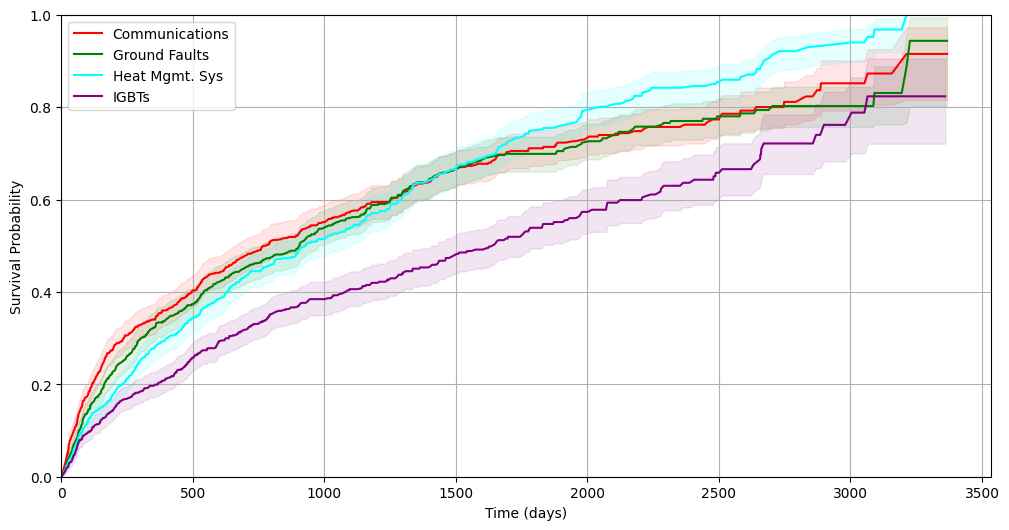

In [30]:
plt.figure(figsize=(12,6))
result = failure_fn_plot(tidy_theta, C_inverter_om, C_all_om, [19,43,55], 'Communications', 'r')
failure_fn_plot(tidy_theta, C_inverter_om, C_all_om, [47,53], 'Ground Faults', 'g')
failure_fn_plot(tidy_theta, C_inverter_om, C_all_om, [45,54,15], 'Heat Mgmt. Sys', 'cyan')
failure_fn_plot(tidy_theta, C_inverter_om, C_all_om, [23,28], 'IGBTs', 'purple')
plt.legend();
plt.grid();
plt.xlim(0,None);
plt.ylim(0,1);

Problem found: in line 9 of SurvivalFns.R, a `TopicOfInterest` column is added to the dataframe, but this is done just via a direct assignment from `Sumthetas$Theta`. I added a print statement in the Python version that prints the length of the two dataframes just before that line of code, and it appears in the cell above. We can see that the two dataframes have different lengths. If this was also the case in the original execution of the code in R, then this could have impacted how topics were assigned to documents and therefore could have had an effect on the results.